## Modeling_GBM/SVR

In [61]:
#yiming

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as scs

import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

import statsmodels as smm
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR

import pygam
from pygam import LinearGAM
from pygam import s,l,f,te

import warnings
import time
warnings.filterwarnings("ignore")



In [2]:
data = pd.read_csv('train_weekly.csv')
test_data = pd.read_csv('test_weekly.csv')
data.Time = pd.to_datetime(data.Time)
test_data.Time = pd.to_datetime(test_data.Time)
# data = data.iloc[::-1].reset_index(drop = True)
# test_data = test_data.iloc[::-1].reset_index(drop = True)

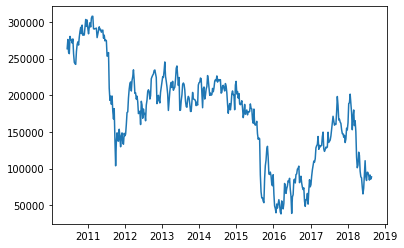

In [3]:
plt.plot(data['Time'],data['AM_NetPos'])

__Predictor Distributions__

In [4]:
data.drop(['Unnamed: 0'], axis = 1, inplace=True)
test_data.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [5]:
def lag_data(data, lag_variable_lst, rewrite_lst):
    if lag_variable_lst:
        data[['lag_'+v for v in lag_variable_lst]] = data[lag_variable_lst].shift(1)
    if rewrite_lst:
        data[rewrite_lst] = data[rewrite_lst].shift(1)
    return data
def diff_data(data, variable_lst):
    data[['diff_'+v for v in variable_lst]] = data[variable_lst].shift(1)
    return data

In [6]:
lag = ['Libor 3 mo', 'Libor 6 mo', 'Libor 1Y', 'T10Y3M', 'T10Y2Y', 'JPY', 'EUR']
rw = ['AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S', 'AM_L', 'AM_S',
       'Lev_L', 'Lev_S','Lev_NetPos']
data = diff_data(lag_data(data, ['AM_NetPos'], rw), lag)
test_data = diff_data(lag_data(test_data, ['AM_NetPos'], rw), lag)

In [7]:
data.drop(['Signal', 'Flag'], axis = 1, inplace = True)
test_data.drop(['Signal', 'Flag'], axis = 1, inplace = True)

data = data.dropna().reset_index(drop = True)
test_data = test_data.dropna().reset_index(drop = True)

In [8]:
data = data.dropna().reset_index(drop = True)
test_data = test_data.dropna().reset_index(drop = True)

In [9]:
p = len(data.columns)
p

46

In [10]:
data['dNetPos'] = data['AM_NetPos'].diff()
test_data['dNetPos'] = test_data['AM_NetPos'].diff()

In [11]:
data = data.dropna().reset_index(drop = True)
test_data = test_data.dropna().reset_index(drop = True)

In [12]:
time_periods = data['Time']
X_train = data.iloc[:,2:p-1]
y_train = data.iloc[:,-1]

X_test = test_data.iloc[:,2:p-1]
y_test = test_data.iloc[:,-1]


In [13]:
data['year'] = pd.DatetimeIndex(data['Time']).year

In [14]:
data.columns

Index(['Time', 'AM_NetPos', 'FedFunds', '1Y OIS', 'Libor 3 mo', 'Libor 6 mo',
       'Libor 1Y', 'T10Y3M', 'T10Y2Y', 'T10YIE', 'JNK_Price', 'SPX',
       'WILL5000INDFC', 'NASDAQCOM', 'GOLD_price', 'VIX', 'VXVCLS', 'GVZCLS',
       'JPY', 'EUR', 'USDX_Close', 'DTWEXBGS', 'FF_Mkt', 'FF_SMB', 'FF_HML',
       'FF_MOM', 'Lev_NetPos', 'AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S',
       'AM_L', 'AM_S', 'Lev_L', 'Lev_S', 'SPY Flows', 'IVV', 'JNK_Volume',
       'lag_AM_NetPos', 'diff_Libor 3 mo', 'diff_Libor 6 mo', 'diff_Libor 1Y',
       'diff_T10Y3M', 'diff_T10Y2Y', 'diff_JPY', 'diff_EUR', 'dNetPos',
       'year'],
      dtype='object')

__Standardization__

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["features"] = X_train.columns

vif_data["VIF"] = [variance_inflation_factor(X_train.values,i) for i in range(len(X_train.columns))]
print(vif_data)

           features           VIF
0          FedFunds  2.323652e+02
1            1Y OIS  3.619400e+02
2        Libor 3 mo  1.879263e+04
3        Libor 6 mo  5.627968e+04
4          Libor 1Y  4.561906e+04
5            T10Y3M  2.754490e+03
6            T10Y2Y  2.995586e+03
7            T10YIE  3.057398e+02
8         JNK_Price  3.245751e+00
9               SPX  1.503217e+02
10    WILL5000INDFC  1.767423e+02
11        NASDAQCOM  1.514465e+01
12       GOLD_price  1.529518e+00
13              VIX  4.890769e+02
14           VXVCLS  9.251841e+02
15           GVZCLS  6.083845e+01
16              JPY  2.876723e+00
17              EUR  2.195102e+01
18       USDX_Close  3.418523e+01
19         DTWEXBGS  6.702504e+00
20           FF_Mkt  1.526547e+00
21           FF_SMB  1.624212e+00
22           FF_HML  1.447378e+00
23           FF_MOM  1.371503e+00
24       Lev_NetPos           inf
25           AM_n_L  4.662832e+02
26           AM_n_S  1.737662e+02
27          Lev_n_L  1.868489e+02
28          Le

In [42]:
vif_data2 = pd.DataFrame()
lasso_X_train = X_train[vars]
vif_data2["features"] = lasso_X_train.columns

vif_data2["VIF"] = [variance_inflation_factor(lasso_X_train.values,i) for i in range(len(lasso_X_train.columns))]
print(vif_data2)

       features         VIF
0      FedFunds    4.538381
1        T10Y3M   34.008404
2        T10YIE  129.247911
3     JNK_Price    2.737426
4           SPX    3.462818
5    GOLD_price    1.294197
6           VIX   29.021824
7        GVZCLS   49.570092
8           JPY    1.634667
9           EUR    2.857247
10     DTWEXBGS    4.781181
11       FF_Mkt    1.444632
12       FF_SMB    1.294997
13       FF_HML    1.340925
14       FF_MOM    1.308961
15    SPY Flows    1.300306
16   JNK_Volume    7.795158
17  lag_Lev_n_L   75.537795
18  lag_Lev_n_S   52.436396
19     lag_AM_L  124.266581
20     lag_AM_S   49.058447
21    lag_Lev_L   62.288562


In [17]:
benchmark_res = pd.DataFrame(index = ['Random Forest'], columns = ['MSE', 'MAE'])

__Random Forest__

In [18]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 20)
rf.fit(X_train_std, y_train)

benchmark_res.loc['Random Forest', 'MSE'] = mean_squared_error(y_test, rf.predict(X_test_std))
benchmark_res.loc['Random Forest', 'MAE'] = mean_absolute_error(y_test, rf.predict(X_test_std))

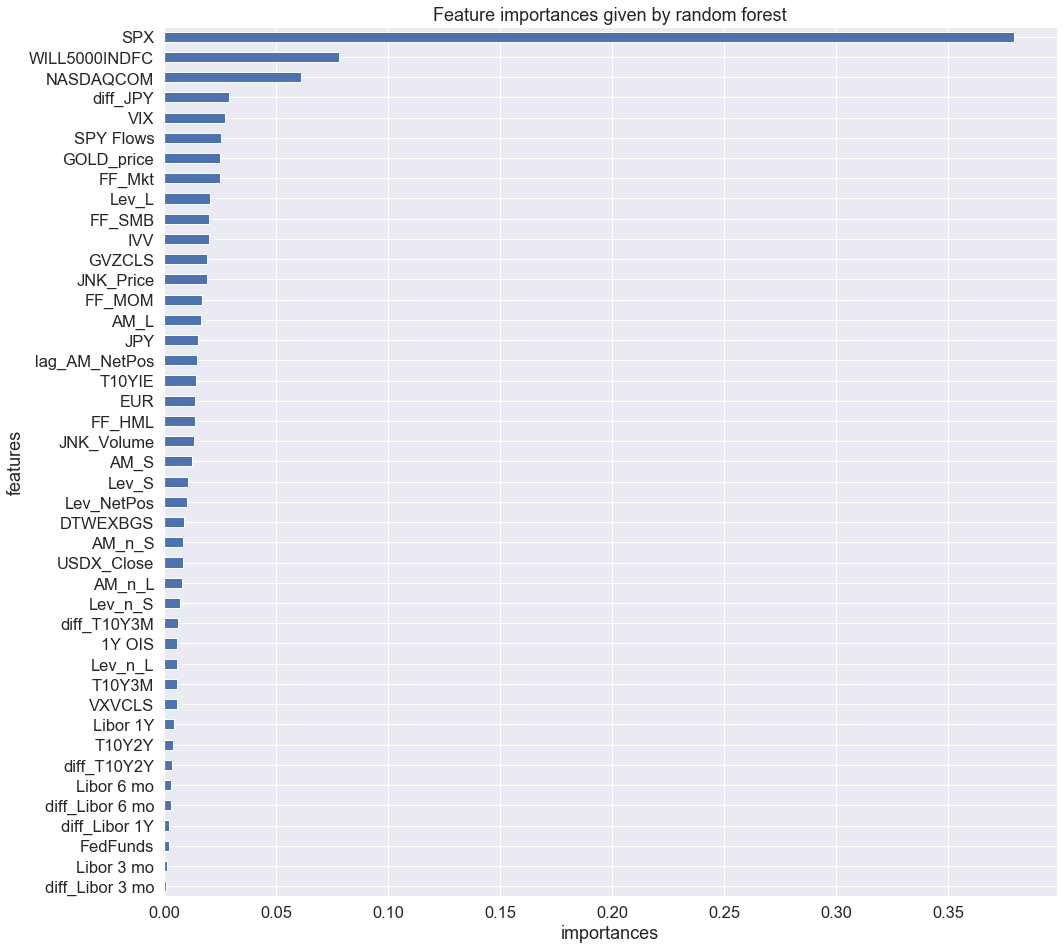

In [19]:
feat_importance = pd.Series(rf.feature_importances_, index = X_train.columns)
sns.set(font_scale = 1.5)
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
fig = plt.figure(figsize = [16,16])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importances')
plt.title("Feature importances given by random forest")
plt.show()

In [20]:
import pandas as pd
from sklearn import preprocessing

x = X_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [21]:
df.columns = X_train.columns

In [22]:
from rfpimp import *
x = dropcol_importances(rf,df,y_train)
del x.index.name

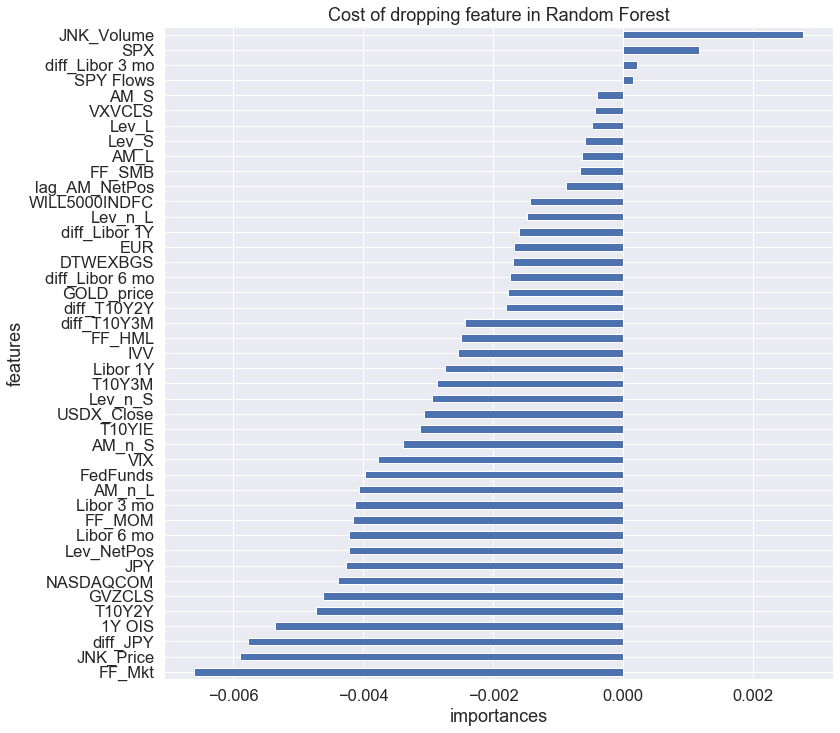

In [23]:

drop_cost = x.squeeze()
fis = np.argsort(drop_cost)
feat_importance = drop_cost[fis]
fig = plt.figure(figsize = [12,12])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importances')
plt.title("Cost of dropping feature in Random Forest")
plt.show()

In [24]:
benchmark_res

,MSE,MAE
Random Forest,1.63077e+08,9437.69


In [25]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 5)

In [26]:
tscv = TimeSeriesSplit(n_splits = 5)

svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=tscv,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)}).fit(X_train_std, y_train)

In [27]:
svr.best_params_

{'C': 1000.0, 'gamma': 0.01}

In [28]:
benchmark_res.loc['SVR', 'MSE'] = mean_squared_error(y_test, svr.predict(X_test_std))
benchmark_res.loc['SVR', 'MAE'] = mean_absolute_error(y_test, svr.predict(X_test_std))

In [29]:
benchmark_res

,MSE,MAE
Random Forest,1.63077e+08,9437.69
SVR,2.24442e+08,10628.4


In [30]:
from sklearn.ensemble import GradientBoostingRegressor

p_test = {'min_samples_split':[20,50,80],'max_depth':[2,4,6,8],'n_estimators':[20,50,100]}

In [31]:
clf = GridSearchCV(GradientBoostingRegressor(), param_grid = p_test, cv = tscv)
clf.fit(X_train_std, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_we...0,
                                                 n_estimators=100,
                                              

In [32]:
clf.best_params_

{'max_depth': 2, 'min_samples_split': 50, 'n_estimators': 100}

In [33]:
params = {'n_estimators': 100, 'max_depth': 2, 'min_samples_split': 50,
          'learning_rate': 0.05}
clf = GradientBoostingRegressor(**params).fit(X_train, y_train)

In [34]:
benchmark_res.loc['Gradient Boosting', 'MSE'] = mean_squared_error(y_test, clf.predict(X_test_std))
benchmark_res.loc['Gradient Boosting', 'MAE'] = mean_absolute_error(y_test, clf.predict(X_test_std))

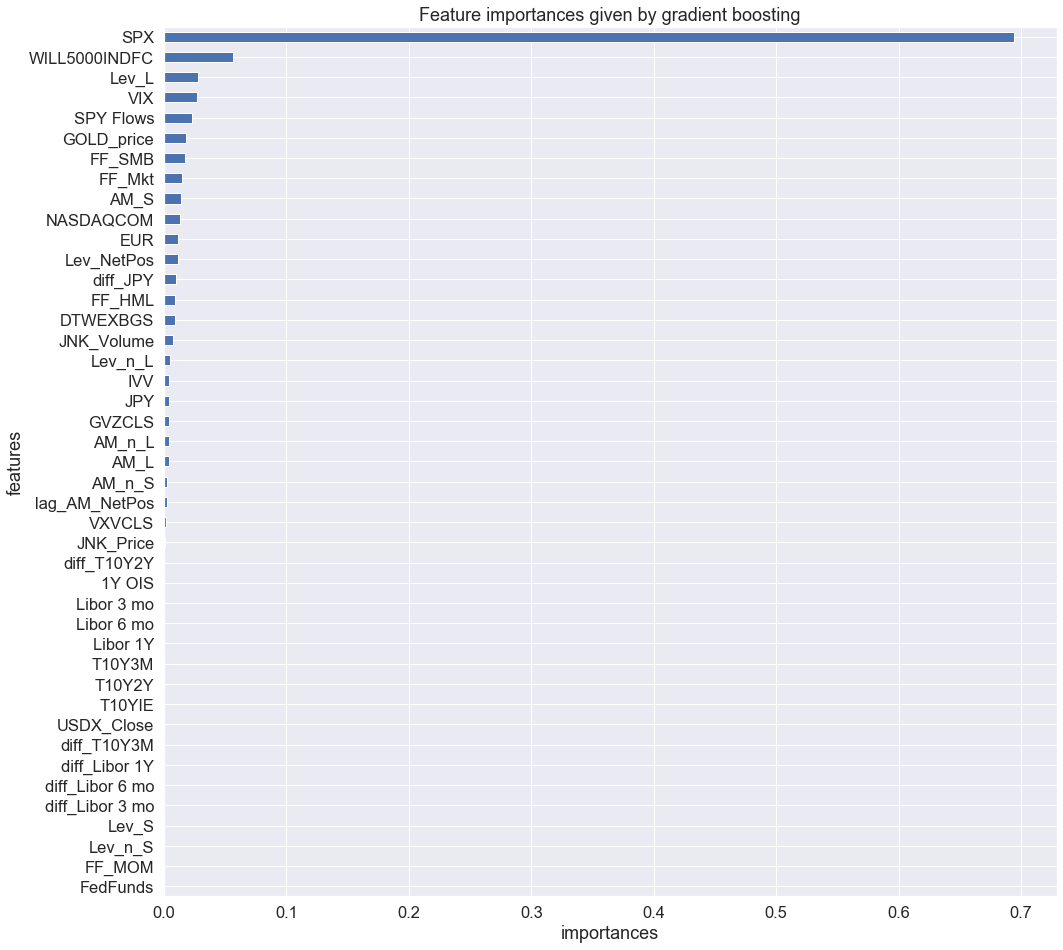

In [35]:
feat_importance = pd.Series(clf.feature_importances_, index = X_train.columns)
sns.set(font_scale = 1.5)
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
fig = plt.figure(figsize = [16,16])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importances')
plt.title("Feature importances given by gradient boosting")
plt.show()

In [36]:
benchmark_res

,MSE,MAE
Random Forest,1.63077e+08,9437.69
SVR,2.24442e+08,10628.4
Gradient Boosting,3.54599e+08,14433.7


In [37]:
pickout = [ 9, 13, 17, 21, 33, 36]

In [38]:
X_train_std_sel = X_train_std[:,pickout]
X_test_std_sel = X_test_std[:,pickout]

In [39]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=tscv,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)}).fit(X_train_std_sel, y_train)

In [40]:
svr.best_params_

{'C': 1000.0, 'gamma': 0.1}

In [41]:
benchmark_res = pd.DataFrame(index = ['SVR after select features'], columns = ['MSE', 'MAE'])
benchmark_res.loc['SVR after select features', 'MSE'] = mean_squared_error(y_test, svr.predict(X_test_std_sel))
benchmark_res.loc['SVR after select features', 'MAE'] = mean_absolute_error(y_test, svr.predict(X_test_std_sel))

In [46]:
ind_year2020 = np.where(test_data['Time'] > "2020-01-01")[0][0]
res_before2020 = pd.DataFrame(index = ['Random Forest'], columns = ['MSE', 'MAE'])
res_2020 = pd.DataFrame(index = ['Random Forest'], columns = ['MSE', 'MAE'])

In [47]:
res_before2020.loc['SVR after select features', 'MSE'] = mean_squared_error(y_test[:ind_year2020], svr.predict(X_test_std_sel[:ind_year2020,:]))
res_before2020.loc['SVR after select features', 'MAE'] = mean_absolute_error(y_test[:ind_year2020], svr.predict(X_test_std_sel[:ind_year2020,:]))

In [48]:
res_2020.loc['SVR after select features', 'MSE'] = mean_squared_error(y_test[ind_year2020:],svr.predict(X_test_std_sel[ind_year2020:,:]))
res_2020.loc['SVR after select features', 'MAE'] = mean_absolute_error(y_test[ind_year2020:], svr.predict(X_test_std_sel[ind_year2020:,:]))

In [49]:
benchmark_res

,MSE,MAE
SVR after select features,1.89105e+08,9523


In [50]:
clf2 = GridSearchCV(GradientBoostingRegressor(), param_grid = p_test, cv = tscv)
clf2.fit(X_train_std_sel, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_we...0,
                                                 n_estimators=100,
                                              

In [51]:
clf2.best_params_

{'max_depth': 4, 'min_samples_split': 50, 'n_estimators': 20}

In [52]:
params = {'n_estimators': 20, 'max_depth': 4, 'min_samples_split': 50,
          'learning_rate': 0.05}
clf2 = GradientBoostingRegressor(**params).fit(X_train_std_sel, y_train)

In [53]:
benchmark_res.loc['Gradient Boosting select features', 'MSE'] = mean_squared_error(y_test, clf2.predict(X_test_std_sel))
benchmark_res.loc['Gradient Boosting select features', 'MAE'] = mean_absolute_error(y_test, clf2.predict(X_test_std_sel))

In [54]:
res_before2020.loc['Gradient Boosting after select features', 'MSE'] = mean_squared_error(y_test[:ind_year2020], clf2.predict(X_test_std_sel[:ind_year2020,:]))
res_before2020.loc['Gradient Boosting after select features', 'MAE'] = mean_absolute_error(y_test[:ind_year2020], clf2.predict(X_test_std_sel[:ind_year2020,:]))

In [55]:
res_2020.loc['Gradient Boosting after select features', 'MSE'] = mean_squared_error(y_test[ind_year2020:], clf2.predict(X_test_std_sel[ind_year2020:,:]))
res_2020.loc['Gradient Boosting after select features', 'MAE'] = mean_absolute_error(y_test[ind_year2020:], clf2.predict(X_test_std_sel[ind_year2020:,:]))

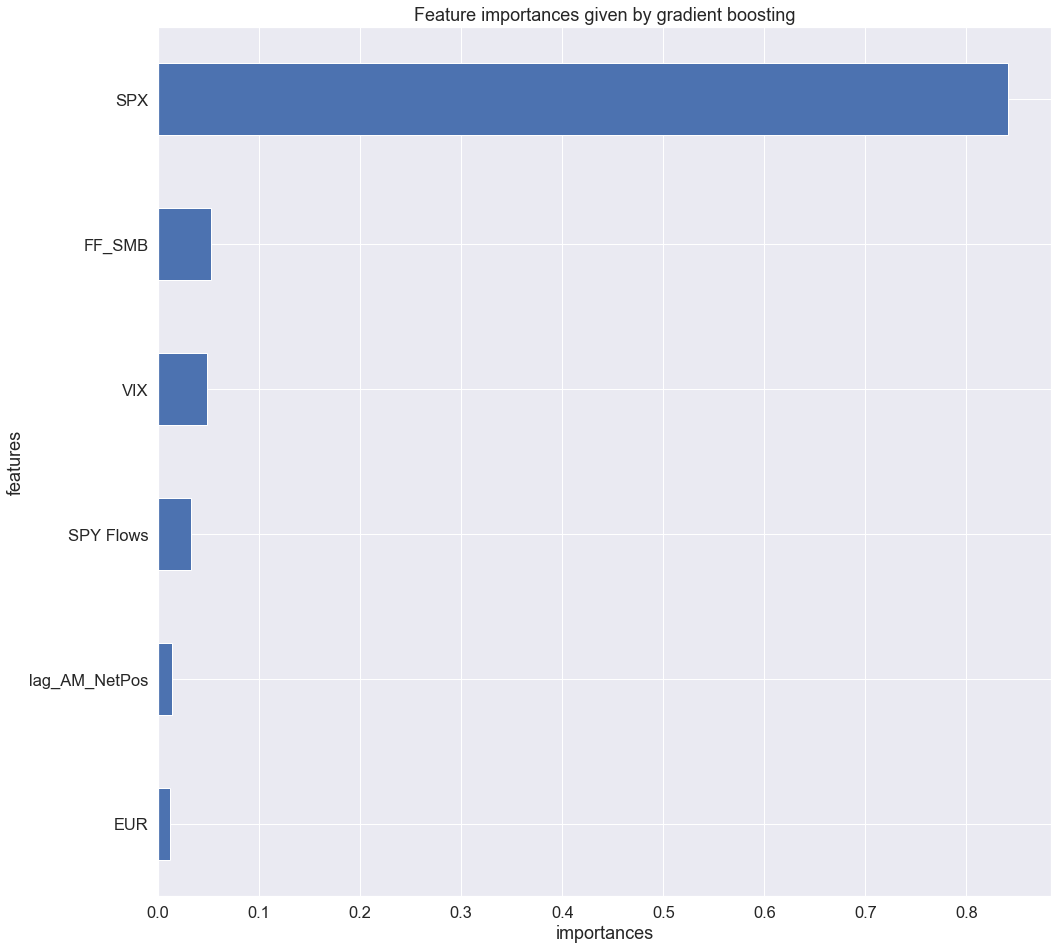

In [57]:
feat_importance = pd.Series(clf2.feature_importances_, index = ['SPX', 'VIX', 'EUR', 'FF_SMB', 'SPY Flows', 'lag_AM_NetPos'])
sns.set(font_scale = 1.5)
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
fig = plt.figure(figsize = [16,16])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importances')
plt.title("Feature importances given by gradient boosting")
plt.show()

In [58]:
benchmark_res

,MSE,MAE
SVR after select features,1.89105e+08,9523
Gradient Boosting select features,1.58421e+08,8860.92


In [59]:
res_before2020

,MSE,MAE
Random Forest,NaN,NaN
SVR after select features,1.72132e+08,8987.24
Gradient Boosting after select features,1.7667e+08,8954.67


In [60]:
res_2020

,MSE,MAE
Random Forest,NaN,NaN
SVR after select features,2.20692e+08,10520.1
Gradient Boosting after select features,1.24456e+08,8686.43
